In [1]:
%matplotlib inline

from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, ShuffleSplit, KFold
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from sklearn.ensemble import RandomForestRegressor
from matplotlib.colors import LogNorm
from matplotlib import pyplot as plt
from sklearn import metrics
import pandas as pd
import numpy as np
import warnings
import glob

warnings.filterwarnings('ignore')

## Notes

* Add ability to reference datasets by DOI in package
* Add function to return citations for current data cache (bibTex or string)
* Add functionality similar to package with > ~ for package specification
* inverse search would be helpful if we keep an index of Data packages
* Package specification could live in an index
* Interface to make it easy to discover which Foundry data packages, and models exist and how they are linked together


In [2]:
from foundry import Foundry
f = Foundry()

In [5]:
requirements = {
          "name": "Band Gap Analysis",
          "version": "1.0.0",
          "description": "Datasets for band gap uber model generation",
          "private":True,
          "dependencies":{
            "_test_foundry_experimental_bandgap_v1.1": "1.1",
            "_test_foundry_mp_bandgap_v1.1":"1.1",
            "_test_foundry_oqmd_bandgap_v1.1":"1.1",
            "_test_foundry_assorted_computational_bandgap_v1.1":"1.1"
          }
        }

In [6]:
for p in requirements['dependencies']:
    f = f.load(p, globus=False, verbose=True)

Headers: {'Authorization': 'Agl8wGJBzyWQgwWqxKXKd4WBmEmWDkq9vE41kyar1enp6gkYywi8CYg3deNKxeblJrVDVbxEpnvB15IJwgXGVirYmB', 'Transfer': 'AgKBxGJWyaBnWJMbrV9GW8NjEP6G3oy0xYJXbDN5JvD309v5lgfeCJ5JomYOwal1aWkrlNO634XENrC15KqmEHzjjJ', 'FuncX': 'AgNyBa5On1qm07rB8YMz1aXN88e1GbK0zOjeEKelrJryOYNaPqSgCy4zQbdM5g5GWKvE9J8mbDxQj8ijyEg97Updxb', 'Petrel': 'Agl8wGJBzyWQgwWqxKXKd4WBmEmWDkq9vE41kyar1enp6gkYywi8CYg3deNKxeblJrVDVbxEpnvB15IJwgXGVirYmB'}
Crawl URL is : http://xtract-crawler-4.eba-ghixpmdf.us-east-1.elasticbeanstalk.com/crawl
Crawl response: <Response [200]>
Crawl ID: 1bcb542b-e673-4d3b-a202-09ae14547df6
<Response [200]>
Crawl Status: {'crawl_id': '1bcb542b-e673-4d3b-a202-09ae14547df6', 'crawl_status': 'initializing'}
Sleeping before re-polling...
<Response [200]>
Crawl Status: {'crawl_id': '1bcb542b-e673-4d3b-a202-09ae14547df6', 'crawl_status': 'initializing'}
Sleeping before re-polling...
<Response [200]>
Crawl Status: {'crawl_id': '1bcb542b-e673-4d3b-a202-09ae14547df6', 'crawl_status': 'init

# Handle computational Band Gaps

In [24]:
f = f.load("_test_foundry_mp_bandgap_v1.1")
X_mp,y_mp = f.load_data()

In [25]:
f = f.load("_test_foundry_oqmd_bandgap_v1.1")
X_oqmd,y_oqmd = f.load_data()

In [26]:
f = f.load("_test_foundry_assorted_computational_bandgap_v1.1")
X_assorted,y_assorted = f.load_data()

In [35]:
X, y = pd.concat([X_oqmd, X_mp, X_assorted]), pd.concat([y_oqmd, y_mp, y_assorted])

In [36]:
X.head()

,reference,icsd_id,structure,composition,comments,BG type,comp method,space group
0,OQMD,NaN,"{'@module': 'pymatgen.core.structure', '@class...",ScCoCuSb,OQMD PBE,,C-PBE,F-43m
1,OQMD,NaN,"{'@module': 'pymatgen.core.structure', '@class...",ScCoCuSb,OQMD PBE,,C-PBE,F-43m
2,OQMD,NaN,"{'@module': 'pymatgen.core.structure', '@class...",GaCoCuSb,OQMD PBE,,C-PBE,F-43m
3,OQMD,NaN,"{'@module': 'pymatgen.core.structure', '@class...",GaCoCuSb,OQMD PBE,,C-PBE,F-43m
4,OQMD,NaN,"{'@module': 'pymatgen.core.structure', '@class...",GaCoCuSb,OQMD PBE,,C-PBE,F-43m


# Add Composition Features

In [52]:
n_datapoints = 100
data = StrToComposition(target_col_id='composition_obj')
data = data.featurize_dataframe(X[0:n_datapoints], 
                                 'composition', 
                                 ignore_errors=True)
y_subset = y[0:n_datapoints]['BG value (eV)']

StrToComposition:   0%|          | 0/100 [00:00<?, ?it/s]

In [53]:
assert(len(y_subset) == len(data))

# Add Other Features

In [54]:
feature_calculators = MultipleFeaturizer([cf.Stoichiometry(), 
                                          cf.ElementProperty.from_preset("magpie"),
                                          cf.ValenceOrbital(props=['avg']), 
                                          cf.IonProperty(fast=True)])
feature_labels = feature_calculators.feature_labels()

data = feature_calculators.featurize_dataframe(data, 
                                               col_id='composition_obj', 
                                               ignore_errors=False);
#data = data.dropna() #TODO: Look into why there are NaN's here...

MultipleFeaturizer:   0%|          | 0/100 [00:00<?, ?it/s]

# Grid Search and Fit Model

In [55]:
quick_demo=True
est = RandomForestRegressor(n_estimators=30 if quick_demo else 150, n_jobs=-1)

model = GridSearchCV(est,
                     param_grid=dict(max_features=range(8,15)),
                     scoring='neg_mean_squared_error',
                     cv=ShuffleSplit(n_splits=1,
                                     test_size=0.1))
model.fit(data[feature_labels], y_subset)


GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=None, test_size=0.1, train_size=None),
             estimator=RandomForestRegressor(n_estimators=30, n_jobs=-1),
             param_grid={'max_features': range(8, 15)},
             scoring='neg_mean_squared_error')

# Cross Validation and Scoring

In [56]:
cv_prediction = cross_val_predict(model, 
                                  data[feature_labels],
                                   y_subset, 
                                  cv=KFold(10, shuffle=True))

In [57]:
for scorer in ['r2_score', 'mean_absolute_error', 'mean_squared_error']:
    score = getattr(metrics,scorer)( y_subset, cv_prediction)
    print(scorer, score)

r2_score -0.06776246639223693
mean_absolute_error 0.01685663888888887
mean_squared_error 0.004569519799379617


# Make Plots

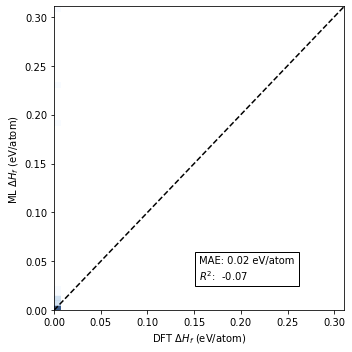

In [58]:
fig, ax = plt.subplots()

ax.hist2d(pd.to_numeric( y_subset),
          cv_prediction, 
          norm=LogNorm(), 
          bins=64, 
          cmap='Blues', 
          alpha=0.8)

ax.set_xlim(ax.get_ylim())
ax.set_ylim(ax.get_xlim())

mae = metrics.mean_absolute_error( y_subset, 
                                  cv_prediction)
r2 = metrics.r2_score( y_subset, 
                      cv_prediction)
ax.text(0.5, 0.1, 'MAE: {:.2f} eV/atom\n$R^2$:  {:.2f}'.format(mae, r2),
        transform=ax.transAxes,
        bbox={'facecolor': 'w', 'edgecolor': 'k'})

ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

ax.set_xlabel('DFT $\Delta H_f$ (eV/atom)')
ax.set_ylabel('ML $\Delta H_f$ (eV/atom)')

fig.set_size_inches(5, 5)
fig.tight_layout()
fig.savefig('oqmd_cv.png', dpi=320)